In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git config --global user.name "alistvt"
!git config --global user.email "alistvt@gmail.com"

%cd /content/drive/MyDrive/multidoc-conv-qa/src/retriever

/content/drive/MyDrive/multidoc-conv-qa/src/retriever


In [4]:
!pip install -r ../../requirements.txt --quiet
!pip install --quiet transformers datasets accelerate

     |████████████████████████████████| 3.8 MB 14.4 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 325 kB 76.0 MB/s 
     |████████████████████████████████| 10.6 MB 60.0 MB/s 
     |████████████████████████████████| 159 kB 66.9 MB/s 
     |████████████████████████████████| 680 kB 59.5 MB/s 
     |████████████████████████████████| 1.2 MB 55.0 MB/s 
     |████████████████████████████████| 248 kB 54.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 880 kB 57.1 MB/s 
     |████████████████████████████████| 6.6 MB 33.6 MB/s 
     |████████████████████████████████| 120 kB 78.3 MB/s 
     |████████████████████████████████| 115 kB 78.0 MB/s 
     |████████████████████████████████| 212 kB 68.4 MB/s 
     |████████████████████████████████| 2.2 MB 66.5 MB/s 
     |██████████████

# Document Retrival with Follow up Detector (DR.FUD) + DR. TEIT

In this method we use a FCN to detect wheter a question is a follow up of the previous question, meaning that the document is the same of not. If the document is the same, we use the previous answer's document for this question also.

We used LaBSE model for out embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

# Dataset
### Dataset Description

- **mutldoc2dial_doc.json** contains the documents that are indexed by key `domain` and `doc_id` . Each document instance includes the following,

  - `doc_id`: the ID of a document;
  - `title`: the title of the document;
  - `domain`: the domain of the document;
  - `doc_text`: the text content of the document (without HTML markups);
  - `doc_html_ts`: the document content with HTML markups and the annotated spans that are indicated by `text_id` attribute, which corresponds to `id_sp`.
  - `doc_html_raw`: the document content with HTML markups and without span annotations.
  - `spans`: key-value pairs of all spans in the document, with `id_sp` as key. Each span includes the following,
    - `id_sp`: the id of a  span as noted by `text_id` in  `doc_html_ts`;
    - `start_sp`/  `end_sp`: the start/end position of the text span in `doc_text`;
    - `text_sp`: the text content of the span.
    - `id_sec`: the id of the (sub)section (e.g. `<p>`) or title (`<h2>`) that contains the span.
    - `start_sec` / `end_sec`: the start/end position of the (sub)section in `doc_text`.
    - `text_sec`: the text of the (sub)section.
    - `title`: the title of the (sub)section.
    - `parent_titles`: the parent titles of the `title`.

- **multidoc2dial_dial_train.json** and **multidoc2dial_dial_validation.json**  contain the training and dev split of dialogue data that are indexed by key `domain` . Please note: **For test split, we only include a dummy file in this version.**

  Each dialogue instance includes the following,

  - `dial_id`: the ID of a dialogue;
  - `turns`: a list of dialogue turns. Each turn includes,
    - `turn_id`: the time order of the turn;
    - `role`: either "agent" or "user";READ
    - `da`: dialogue act;
    - `references`: a list of spans with `id_sp` ,  `label` and `doc_id`. `references` is empty if a turn is for indicating previous user query not answerable or irrelevant to the document. **Note** that labels "*precondition*"/"*solution*" are fuzzy annotations that indicate whether a span is for describing a conditional context or a solution.
    - `utterance`: the human-generated utterance based on the dialogue scene.
Downloading the training dataset:

In [5]:
import json
with open('../../dataset/multidoc2dial/v1.0/multidoc2dial_doc.json', 'r') as f:
    multidoc2dial_doc = json.load(f)

#### Extracting titles

In [6]:
titles = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        titles.append(doc_idx2)

#### Extracting document texts

In [7]:
doc_texts_train = []
title_to_domain = {}
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())
        title_to_domain[doc_idx2] = doc_idx1

## Encoding the sentences
We use the LaBSE which is a Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

In [8]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import numpy as np
import torch
from torch.nn.functional import normalize

from tqdm import tqdm

model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/576 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

### `get_embeddings`
In this method we extract the **pooler output** (Last layer hidden-state of the first token of the sequence (classification token) after further processing through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining).

In [9]:
def get_embeddings(sentece):
    """
    Return embeddings based on encoder model

    :param sentence: input sentence(s)
    :type sentence: str or list of strs
    :return: embeddings
    """
    tokenized = tokenizer(sentece,
                                return_tensors="pt",
                                padding=True)
    with torch.no_grad():
        embeddings = model(**tokenized)
    
    return np.squeeze(np.array(embeddings.pooler_output))

### Title embedding

In [10]:
import os
title_embeddings_file = 'doc_title_LaBSE_Embedding.npy'

if not os.path.exists(title_embeddings_file):
    title_embeddings = []
    for title in tqdm(titles):
        title_embeddings.append(get_embeddings(title))

    with open(title_embeddings_file, 'wb') as f:
        np.save(f, np.array(title_embeddings))
else:
    title_embeddings = np.load(title_embeddings_file)
    title_embeddings = list(title_embeddings)


In [11]:
import pickle
title_to_embeddings_file = 'title_to_embeddings.pkl'

if not os.path.exists(title_to_embeddings_file):
    title_to_embeddings = {}
    for title in tqdm(titles):
        title_to_embeddings[title] = get_embeddings(title)
    with open(title_to_embeddings_file, 'wb') as f:
        pickle.dump(title_to_embeddings, f)
else:
    with open(title_to_embeddings_file, 'rb') as f:
        title_to_embeddings = pickle.load(f)

## Calculating the IDF for each token

In [12]:
words_idf_file = 'IDFs.pkl'
N_doc = len(doc_texts_train)

if not os.path.exists(words_idf_file):
    # First getting all distinct words in all documents
    words = set()
    doc_texts_train_tokenized = []
    for doc in tqdm(doc_texts_train, desc="getting all words from documents"):
        tokenized_doc = [s.lower() for s in tokenizer.tokenize(doc)]
        doc_texts_train_tokenized.append(tokenized_doc) 
        words = set(tokenized_doc).union(words)

    # calculating each word IDF
    words2IDF = {}
    for word in tqdm(words, desc="calculating words IDF scores"):
        n_word = 0
        for doc in doc_texts_train_tokenized:
            if word in doc:
                n_word += 1
        words2IDF[word] = np.log(N_doc / (n_word + 1))

    with open(words_idf_file, 'wb') as f:
        pickle.dump(words2IDF, f)

else:
    with open(words_idf_file, 'rb') as f:
        words2IDF = pickle.load(f)

In [13]:
len(words2IDF)

8446

In [14]:
def calc_idf_score(sentence):
    """
    Calculate the mean idf score for given sentence.
    (used to understand the contribution of the knowledge of each question
    questions with high frequent words are meaningless and we can ignore them
    roughly, which is done by this score.)

    :param sentence: input sentence
    :type sentence: str
    :return: mean idf score of sentence token
    """
    tokenzied_sentence = [s.lower() for s in tokenizer.tokenize(sentence)]
    score = 0
    for token in tokenzied_sentence:
        if token in words2IDF:
            score += words2IDF[token]
        else:
            score += np.log(N_doc)
    return score / len(tokenzied_sentence) if len(tokenzied_sentence) else 0

## Constructing the Follow-up Dataset

``` history | question | is_follow_up```

is_follow_up: shows that the history's document is the same as the current question's.

In [15]:
def combine_sentences(s1, s2):
    separation_token = " <SEP> "
    return s1 + separation_token + s2


def construct_followup_dataset(filepath):
    import json
    with open(filepath, 'r') as f:
        multidoc2dial_dial_train = json.load(f)
    
    historys = []
    questions = []
    combined = []
    labels = []
    prev_docs = []
    current_docs = []

    for domain in multidoc2dial_dial_train['dial_data']:
        for dial in multidoc2dial_dial_train['dial_data'][domain]:
            prev_doc = ''
            prev_question = ''
            for turn in dial['turns']:
                if turn['role'] == "user":
                    current_question = turn['utterance']
                    historys.append(prev_question)
                    questions.append(current_question)
                    
                    combined.append(combine_sentences(prev_question, current_question))

                    current_doc = turn['references'][0]['doc_id']
                    labels.append(int(current_doc==prev_doc))

                    prev_docs.append(prev_doc)
                    current_docs.append(current_doc)

                    prev_doc, prev_question = current_doc, current_question
                    
    return historys, questions, combined, labels, prev_docs, current_docs

In [16]:
import pandas as pd

train_history, train_questions, train_combined, train_labels, train_prev_docs, train_current_docs = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json')
test_history, test_questions, test_combined, test_labels, test_prev_docs, test_current_docs = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_validation.json')

train_dict_dataset = {"history":train_history, "question": train_questions, "combined": train_combined, "followup": train_labels, "prev_doc": train_prev_docs, "current_doc": train_current_docs}
test_dict_dataset = {"history":test_history, "question": test_questions, "combined": test_combined, "followup": test_labels, "prev_doc": test_prev_docs, "current_doc": test_current_docs}

train_df = pd.DataFrame(train_dict_dataset)
test_df = pd.DataFrame(test_dict_dataset)

In [17]:
max([len(x["combined"].split()) for _, x in test_df.iterrows()])

74

In [18]:
train_df

,history,question,combined,followup,prev_doc,current_doc
0,,"Hello, I forgot o update my address, can you h...","<SEP> Hello, I forgot o update my address, ca...",0,,Top 5 DMV Mistakes and How to Avoid Them#3_0
1,"Hello, I forgot o update my address, can you h...",Can I do my DMV transactions online?,"Hello, I forgot o update my address, can you h...",1,Top 5 DMV Mistakes and How to Avoid Them#3_0,Top 5 DMV Mistakes and How to Avoid Them#3_0
2,Can I do my DMV transactions online?,You've got it. Another query about DMV. What h...,Can I do my DMV transactions online? <SEP> You...,0,Top 5 DMV Mistakes and How to Avoid Them#3_0,Registration suspensions for failure to pay to...
3,You've got it. Another query about DMV. What h...,"Besides that, will I receive a notice?",You've got it. Another query about DMV. What h...,1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...
4,"Besides that, will I receive a notice?",If you submit the affidavit?,"Besides that, will I receive a notice? <SEP> I...",1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...
...,...,...,...,...,...,...
23394,"By the way, who can I contact to give me infor...",What if I've fallen behind on one or more loan...,"By the way, who can I contact to give me infor...",0,Loan Servicers | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0
23395,What if I've fallen behind on one or more loan...,I have another question regarding the Military...,What if I've fallen behind on one or more loan...,0,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Deferment | Federal Student Aid#1_0
23396,I have another question regarding the Military...,something else I want to ask about FAFSA. What...,I have another question regarding the Military...,0,Student Loan Deferment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0
23397,something else I want to ask about FAFSA. What...,How can I make a payment by post?,something else I want to ask about FAFSA. What...,1,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0


In [19]:
def tokenize_function(examples, prediction=False, cuda=False):
    if prediction:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    else:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True)
    if cuda:
        tokenized_cuda = {}
        for key, value in tokenized.items():
            tokenized_cuda[key] = value.cuda()
        return tokenized_cuda
    else:
        return tokenized

### constructing dataloader

In [20]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_trainset = train_dataset.map(tokenize_function, batched=True)
tokenized_testset = test_dataset.map(tokenize_function, batched=True)

tokenized_trainset = tokenized_trainset.rename_column("followup", "label")
tokenized_testset = tokenized_testset.rename_column("followup", "label")

fud_dataset = DatasetDict()

fud_dataset['train'] = tokenized_trainset
fud_dataset['validation'] = tokenized_testset


  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

# Methods

## FCN based on [cls]

### AutoModelForSequenceClassification

We use a classification method on the questions to decide the relationship between the previous question and current question.
In the dataset provided to us, previous turn documents are predefined, meaning that we are aware of the previous documents, therefore, if the prediction predicts that current question's document is the same as the previous, we don't need to retrieve a document and we give the previous doc_id.

#### model

In [21]:
model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
fudnet_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda:0")
fudnet_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at setu4993/LaBSE and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

#### metrics

In [22]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### train

In [23]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/home/',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy ='epoch',
    load_best_model_at_end=True,
    # auto_find_batch_size=True,
)

trainer = Trainer(
    model=fudnet_model,
    args=training_args,
    train_dataset=fud_dataset['train'],
    eval_dataset=fud_dataset['validation'],
    compute_metrics=compute_metrics
)

In [24]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: prev_doc, current_doc, question, combined, history. If prev_doc, current_doc, question, combined, history are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23399
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 732


Epoch,Training Loss,Validation Loss,Accuracy
1,0.154000,0.132905,0.951735


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: prev_doc, current_doc, question, combined, history. If prev_doc, current_doc, question, combined, history are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4496
  Batch size = 32
Saving model checkpoint to /home/checkpoint-732
Configuration saved in /home/checkpoint-732/config.json
Model weights saved in /home/checkpoint-732/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /home/checkpoint-732 (score: 0.1329050064086914).


TrainOutput(global_step=732, training_loss=0.19589173704222904, metrics={'train_runtime': 388.7458, 'train_samples_per_second': 60.191, 'train_steps_per_second': 1.883, 'total_flos': 1539133896092160.0, 'train_loss': 0.19589173704222904, 'epoch': 1.0})

In [26]:
# trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: current_doc, prev_doc, combined, question, history. If current_doc, prev_doc, combined, question, history are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23399
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2196


Epoch,Training Loss,Validation Loss,Accuracy
1,0.171200,0.153878,0.945952
2,0.124500,0.146333,0.953737
3,0.056600,0.154310,0.955294


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: current_doc, prev_doc, combined, question, history. If current_doc, prev_doc, combined, question, history are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4496
  Batch size = 32
Saving model checkpoint to /home/checkpoint-732
Configuration saved in /home/checkpoint-732/config.json
Model weights saved in /home/checkpoint-732/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: current_doc, prev_doc, combined, question, history. If current_doc, prev_doc, combined, question, history are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4496
  Batch si

TrainOutput(global_step=2196, training_loss=0.1324051207945918, metrics={'train_runtime': 1177.0652, 'train_samples_per_second': 59.637, 'train_steps_per_second': 1.866, 'total_flos': 4617401688276480.0, 'train_loss': 0.1324051207945918, 'epoch': 3.0})

### DR. TEIT*

In this method we used two scoring measure and aggregate them by a convex combination as below:
$$
λ*Similiarity_{Title Embedding} + (1-λ)*Similiarity_{TextIDF}
$$

We used LaBSE model for our embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

For the second part we used character-level (2gram to 8gram). We also trained our TF-IDF transformation matrix on the Multidoc2dial2022 documnets.

**NOTE: In `predict_DR_TEIT` you may see a diffrent notation (`alpha`) but they are the same.**

#### TF-IDF Transformation Matrix Fitting

In [25]:
doc_texts_train = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(strip_accents=None,
                                 analyzer='char',
                                 ngram_range=(2, 8),
                                 norm='l2',
                                 use_idf=True,
                                 smooth_idf=True)
tfidf_wm = tfidfVectorizer.fit_transform(doc_texts_train)

In [27]:
import pickle
with open('tfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(tfidfVectorizer, f)

with open('tfidf_wm.pkl', 'wb') as f:
    pickle.dump(tfidf_wm, f)

In [28]:
len(tfidfVectorizer.get_feature_names_out())

1047632

#### DR. TEIT

the input is consisted of a list of queries, which is the current question and its history turns.
for each of the questions, we compute two similarity score for each of our documents, one of them is based on the pretrained LM and the other on is based on character level matching. Both of these scores will be weighted by a coefficient which is the `idf_score` of the query, defining how much meaning does the query contain. Then these scores will be summed up in a convex manner and the final matching score with all documents is computed. We return the result by sorting these scores.

In [29]:
def predict_DR_TEIT(queries, k=1, alpha=10):
    """
    Predict which document is matched to the given query.

    :param queries: input queries in time reversed order (latest first)
    :type queries: str (or list of strs)
    :param k: number of returning docs
    :type k: int 
    :return: return the document names and accuracies
    """

    idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    coef_sum = 0
    for i, query in enumerate(queries):
        query_embd = get_embeddings(query)
        query_sim = list(map(lambda x: np.dot(x, query_embd) /
                            (np.linalg.norm(query_embd) * np.linalg.norm(x)),
                            title_embeddings))
        query_sim = np.array(query_sim)
        coef = 2**(-i) * calc_idf_score(query)
        coef_sum += coef

        idf_score += coef * query_sim
        tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

    scores = (idf_score + alpha * tfidf_score) / coef_sum
    best_k_idx = scores.argsort()[::-1][:k]
    scores = scores[best_k_idx]
    predictions = list(map(lambda x: titles[x], best_k_idx))
    return (scores, predictions)

### FUDNet + DR. TEIT

In [50]:
def predict_FUDNet_DR_TEIT(data, k=1):
    dr_scores, dr_predictions = predict_DR_TEIT([data['history'], data['question']], k=k)
    
    inputs = tokenize_function(data, prediction=True, cuda=True)
    outputs = fudnet_model(**inputs)
    prediction = torch.argmax(outputs.logits)
    if bool(prediction):
        return [data['prev_doc']] + dr_predictions[:k-1]
    else:
        return dr_predictions

In [44]:
predict_FUDNet_DR_TEIT(test_df.loc[1], k=5)

tensor(1, device='cuda:0')


['Top 5 DMV Mistakes and How to Avoid Them#3_0',
 'New York State Insurance Requirements#3_0',
 'Insurance lapses#3_0',
 'Respond to DMV insurance letters and orders#3_0',
 'VA Life Insurance | Veterans Affairs#2_0']

# Test
In the test dataset we just picked ones with **user** turn.

In [60]:
def test_loop(test_dataset):
    prec_at_50 = 0
    prec_at_10 = 0
    prec_at_5 = 0
    prec_at_1 = 0
    ranks = []
    for index, data in tqdm(test_df.iterrows()):
        predictions = predict_FUDNet_DR_TEIT(data, k=500)
        actual_doc = data['current_doc']
        ranks.append(1 / (predictions.index(actual_doc) + 1))
        if actual_doc == predictions[0]:
            prec_at_1 += 1
        if actual_doc in predictions[:5]:
            prec_at_5 += 1
        if actual_doc in predictions[:10]:
            prec_at_10 += 1
        if actual_doc in predictions[:50]:
            prec_at_50 += 1

    return f"""
        MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
        Prec@(1) = {prec_at_1 / index}
        Prec@(5) = {prec_at_5 / index}
        Prec@(10) = {prec_at_10 / index}
        Prec@(50) = {prec_at_50 / index}
        NUMBER_OF_SAMPLES = {index}
    """

In [61]:
print(test_loop(test_df))

4496it [23:17,  3.22it/s]


        MRR: mean=0.7916426778316141, var=0.13268449646742903
        Prec@(1) = 0.7423804226918799
        Prec@(5) = 0.8518353726362625
        Prec@(10) = 0.8938820912124583
        Prec@(50) = 0.9650723025583983
        NUMBER_OF_SAMPLES = 4495
    


# Results

At last we have resutls as follows:


| Method | @1 | @5 | @10 | @50 | @100 | MRR (mean, var) |
|:------:|:------:|:------:|:-------:|:-------:|:--------:|:---:|
| IDF - vanilla | 13% | 30% | 39% | 64% | 83% | (0.22, 0.11) |
| IDF - power-order | 15% | 31% | 41% | 65% | 83% | (0.23, 0.12) |
| IDF - power-order (softmax) | 10.7% | 23% | 31% | 57.6% | 78% | (0.18, 0.09) |
| IDF - self-attention | 13.9% | 29% | 38% | 62% | 82% | (0.22, 0.11) |
| DR. TEIT | **61.6%** | **86%** | **91%** | **96%** | **98%** | **(0.72, 0.13)** |
| **FUDNet + DR. TEIT** | **74.2%** | **85.18%** | **89%** | **96%** | **98%** | **(0.79, 0.13)** |

# drafts

In [ ]:
def simple_fudnet_test():
  data = {"combined": " <SEP> Hello. how can you help me?", "label": 0}
  inputs = tokenize_function(data, prediction=True, cuda=True)
  labels = torch.tensor([data['label']]).unsqueeze(0)  # Batch size 1
  outputs = fudnet_model(**inputs)
  prediction = torch.argmax(outputs.logits)
  print(prediction)

simple_test()

In [ ]:
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5EncoderModel
import torch

model_name = ["setu4993/LaBSE", "t5-small", "bert-base-uncased"][0]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenizer = T5Tokenizer.from_pretrained("t5-base")
# model = T5EncoderModel.from_pretrained("t5-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print("inputs", inputs)

print("last_hidden_states", last_hidden_states.shape)

# pooler = outputs.pooler_output
# print("pooler",pooler.shape)
# with torch.no_grad():
#     print(np.squeeze(np.array(pooler)).shape)

In [ ]:
import numpy as np

from utils import scaled_dot_product_attention

inputs = tokenizer(["Hello, my dog is cute", "Yes this is a beautiful dog and you can have it."], max_length=16, padding="max_length", return_tensors="pt")
outputs = model(**inputs)

query=last_hidden_states[0, :, :]
key=last_hidden_states[1, :, :]
value=last_hidden_states[1, :, :]

context, attention = scaled_dot_product_attention(
    query=query,
    key=key,
    value=value,
)

In [ ]:
context.shape , attention.shape

(torch.Size([16, 768]), torch.Size([16, 16]))

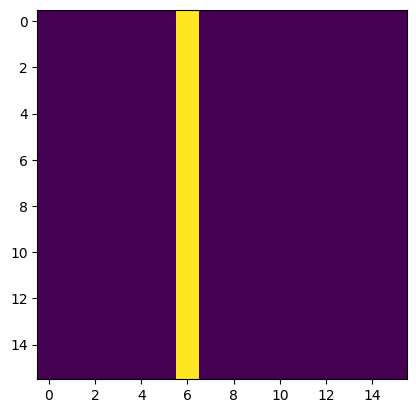

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    plt.imshow(attention, interpolation='nearest')
    plt.show()


In [ ]:
attention

tensor([[4.1652e-05, 1.8743e-08, 4.3531e-15, 1.3554e-17, 2.0464e-16, 1.3552e-08,
         9.9992e-01, 1.8685e-20, 2.9881e-23, 3.2375e-22, 4.0948e-22, 5.8909e-23,
         5.1022e-18, 4.1652e-05, 1.0425e-15, 3.1295e-16],
        [6.9659e-16, 5.0016e-07, 1.9475e-12, 6.0816e-15, 4.3889e-14, 1.0717e-07,
         1.0000e+00, 1.2967e-17, 1.6856e-19, 1.3311e-18, 2.6679e-18, 2.0186e-19,
         6.4972e-16, 6.9659e-16, 3.3120e-14, 1.4395e-14],
        [2.8160e-17, 4.6376e-12, 3.3828e-09, 3.1156e-10, 7.6270e-09, 3.4791e-07,
         1.0000e+00, 1.6709e-13, 7.2155e-15, 7.7347e-15, 2.2479e-14, 1.4072e-14,
         3.9355e-12, 2.8160e-17, 7.8200e-14, 8.5553e-14],
        [8.9966e-22, 3.2495e-17, 1.8656e-13, 6.4120e-14, 1.5420e-11, 2.0936e-09,
         1.0000e+00, 3.8246e-18, 1.3870e-19, 3.8302e-19, 3.0957e-18, 2.5225e-19,
         1.7452e-17, 8.9966e-22, 3.4182e-18, 3.9053e-18],
        [1.0318e-33, 1.2762e-28, 2.2427e-30, 7.8236e-32, 1.9107e-27, 3.6965e-22,
         1.0000e+00, 3.1281e-36, 1.3927